## Imports

In [2]:
import os
import os.path as osp
import pandas as pd
import SQUIDp.util as sqd
import numpy as np
import sys
from skimage.measure import regionprops
# from SQUIDp.data import get_cell_ids_in_patch, match_patch_id_to_expr, match_patch_id_to_PIL, plots_n_visualizations
from hest import iter_hest


## Functions (in dev)

In [3]:
def get_cell_ids_in_patch(sdata, patch_size=224, log_file=None):
    '''
    Input:
    sdata: spatialdata object
    patch_range: a tuple of (x_start, x_end, y_start, y_end)

    Output:
    patch_id_to_cell_id: a dict that maps each patch id (y_patch_idx, x_patch_idx) to a list of cell ids
    '''
    he_nuc_mask = sdata['ST_downscaled_hires_image'][0, :, :].to_numpy()
    regions = regionprops(he_nuc_mask)
    
    # initialize a dict to hold cell ids by patch
    # {(y_patch_idx, x_patch_idx): [cell_ids]}
    patch_id_to_cell_id = dict()
    for props in regions:

        # get id and coord of cell
        cid = props.label
        y_center, x_center = int(props.centroid[0]), int(props.centroid[1])

        # find y, x index of the bucket this cell should be in
        y_patch_idx = y_center // patch_size
        x_patch_idx = x_center // patch_size

        # if the patch is not in the dict, create it
        patch_key = (y_patch_idx, x_patch_idx)
        if patch_key not in patch_id_to_cell_id:
            patch_id_to_cell_id[patch_key] = []

        # append the cell
        patch_id_to_cell_id[patch_key].append(cid)
    
    cell_counts = [len(cell_ids) for cell_ids in patch_id_to_cell_id.values()]

    # collect stats
    if log_file is not None:
        with open(log_file, 'a') as f:
            f.write(f"HE Nucleus Mask of dimension: {he_nuc_mask.shape}\n")
            f.write(f"Number of cells in this slide: {len(regions)}\n")
            f.write(f"Number of patches: {len(patch_id_to_cell_id)}\n")
            f.write(f"Patch size: {patch_size}\n")
            if cell_counts:
                f.write(f"Minimum number of cells in a patch: {min(cell_counts)}\n")
                f.write(f"Maximum number of cells in a patch: {max(cell_counts)}\n")
                f.write(f"Average number of cells in a patch: {np.mean(cell_counts):.3f}\n")
            else:
                f.write("No cells found in any patches.\n")

    return patch_id_to_cell_id

# matches each patch id (y_patch_idx, x_patch_idx) to the actual patch
def match_patch_id_to_PIL(sdata, patch_id_to_cell_id, patch_size=224, log_file=None):
    '''
    Input:
    patch_id_to_cell_id: a dict that maps each patch id (y_patch_idx, x_patch_idx) to a list of cell ids
    sdata: spatialdata object
    patch_size: size of the patch

    Output:
    patch_id_to_pil: a dict that maps each patch id (y_patch_idx, x_patch_idx) to the actual patch
    '''
    # reshape nparray into (w, h, c) and convert to PIL
    he_image = np.transpose(sdata['HE_original'].to_numpy(), (1, 2, 0))
    he_pil = Image.fromarray(he_image.astype(np.uint8))

    # initialize a dict to pil image by patch id
    # {(y_patch_idx, x_patch_idx): PIL image}
    patch_id_to_pil = dict()
    for patch_key in patch_id_to_cell_id.keys():

        y_patch_idx, x_patch_idx = patch_key

        # define the four corners of the patch
        x_start = x_patch_idx * patch_size
        x_end = x_start + patch_size
        y_start = y_patch_idx * patch_size
        y_end = y_start + patch_size
        
        # check if the patch is within the bounds of the image
        if x_start < 0 or x_end > he_image.shape[1] or y_start < 0 or y_end > he_image.shape[0]:
            with open(log_file, 'a') as f:
                f.write(f"Patch ({x_start}, {x_end}, {y_start}, {y_end}) is out of bounds. Skipped. \n")
            continue

        # obtain the patch and store in dict
        patch_pil = he_pil.crop((x_start, y_start, x_end, y_end))
        patch_id_to_pil[patch_key] = patch_pil

    # collect stats
    if log_file is not None:
        with open(log_file, 'a') as f:
            f.write(f"Number of patches with valid images: {len(patch_id_to_pil)}\n")
    
    return patch_id_to_pil

# matches each patch id (y_patch_idx, x_patch_idx) to the average expression of cells in that patch
def match_patch_id_to_expr(sdata, patch_id_to_cell_id, patch_id_to_pil, log_file=None):
    '''
    Input:
    sdata: spatialdata object
    patch_id_to_cell_id: a dict that maps each patch id (y_patch_idx, x_patch_idx) to a list of cell ids

    Output:
    patch_id_to_expression: a dict that maps each patch id (y_patch_idx, x_patch_idx) to the average expression
    of cells in that patch, stored as (460,)
    '''
    file_name = sdata.path.name

    # get the expression data
    expr_data = sdata['anucleus']

    patch_id_to_expr = dict()
    patch_id_to_delete = []
    for patch_key, cell_ids in patch_id_to_cell_id.items():

        # get a subset of expression data of shape (n_cells_in_this_patch, 460)
        subset = expr_data[expr_data.obs['cell_id'].isin(cell_ids)]

        # if subset is empty, this patch contains no cells that we can use for train
        # add this patch id to the list of patches to delete
        if subset.shape[0] == 0:
            patch_id_to_delete.append(patch_key)
            continue

        # get average expression vector
        avg_expr = subset.X.toarray().mean(axis=0)

        # store in dict
        patch_id_to_expr[patch_key] = avg_expr

    # process previous dicts to remove empty patches
    for patch_key in patch_id_to_delete:
        del patch_id_to_cell_id[patch_key]
        del patch_id_to_pil[patch_key]
    
    # collect stats
    if log_file is not None:
        with open(log_file, 'a') as f:
            f.write(f"Max average expression: {max([np.mean(expr) for expr in patch_id_to_expr.values()])}\n")
            f.write(f"Min average expression: {min([np.mean(expr) for expr in patch_id_to_expr.values()])}\n")
            f.write(f"Deleted {len(patch_id_to_delete)} patches with no cells containing expression information\n")
            f.write(f"Number of remaining patches (which has valid expression data): {len(patch_id_to_expr)}\n")
            filter_only_1_patch_id = {key: value for key, value in patch_id_to_cell_id.items() if len(value) == 10}
            f.write(f"Number of patches with at least 10 cells: {len(filter_only_1_patch_id)}\n")
            filter_10_patch_id = {key: value for key, value in patch_id_to_cell_id.items() if len(value) >= 10}
            f.write(f"Number of patches with at least 10 cells: {len(filter_10_patch_id)}\n")
            filter_100_patch_id = {key: value for key, value in patch_id_to_cell_id.items() if len(value) >= 100}
            f.write(f"Number of patches with at least 100 cells: {len(filter_100_patch_id)}\n")

    return patch_id_to_cell_id, patch_id_to_pil, patch_id_to_expr

# makes plots and visualizations
def plots_n_visualizations(sdata, patch_id_to_cell_id, patch_id_to_pil, patch_id_to_expr, plot_dir):
    '''
    Input:
    sdata: spatialdata object
    patch_id_to_cell_id: a dict that maps each patch id (y_patch_idx, x_patch_idx) to a list of cell ids
    patch_id_to_pil: a dict that maps each patch id (y_patch_idx, x_patch_idx) to the actual patch
    patch_id_to_expr: a dict that maps each patch id (y_patch_idx, x_patch_idx) to the average expression

    Note these plots corresponds to the dicts that already filtered out the
    patches that contain cells with no expression information

    Output:
    None
    '''
    file_name = sdata.path.name

    # fig1 check distribution of cell counts
    cell_counts = [len(cell_ids) for cell_ids in patch_id_to_cell_id.values()]
    plt.hist(cell_counts, bins=50)
    plt.xlabel('Number of cells in patch')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of cell counts in patches for {file_name}')
    plt.savefig(f"{plot_dir}/cell_counts_per_patch_{file_name}.png")
    plt.close()

    # fig2 check distribution of average expression
    # plot 6 patches: max # cells, min # cells, (50,50), 3 random
    max_patch_idx = list(patch_id_to_cell_id.keys())[np.argmax([len(id_list) for id_list in patch_id_to_cell_id.values()])]    # rip readability
    max_patch_n_cells = len(patch_id_to_cell_id[max_patch_idx])
    min_patch_idx = list(patch_id_to_cell_id.keys())[np.argmin([len(id_list) for id_list in patch_id_to_cell_id.values()])]
    min_patch_n_cells = len(patch_id_to_cell_id[min_patch_idx])

    # approximate center patch
    patch_keys = list(patch_id_to_cell_id.keys())
    avg_y = int(np.round(np.mean([y for y, x in patch_keys])))
    avg_x = int(np.round(np.mean([x for y, x in patch_keys])))
    center_patch_idx = (avg_y, avg_x)
    # check if center patch is in the dict
    if center_patch_idx not in patch_id_to_cell_id:
        center_patch_idx = random.choice(patch_keys)

    center_patch_n_cells = len(patch_id_to_cell_id[center_patch_idx])
    random_patch_idx = random.sample(list(patch_id_to_cell_id.keys()), k=3)
    random_patch_n_cells = [len(patch_id_to_cell_id[idx]) for idx in random_patch_idx]

    _, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs[0, 0].imshow(patch_id_to_pil[max_patch_idx])
    axs[0, 0].set_title(f"Max cells: {max_patch_n_cells} at {max_patch_idx}")
    axs[0, 1].imshow(patch_id_to_pil[min_patch_idx])
    axs[0, 1].set_title(f"Min cells: {min_patch_n_cells} at {min_patch_idx}")
    axs[0, 2].imshow(patch_id_to_pil[center_patch_idx])
    axs[0, 2].set_title(f"Center patch: {center_patch_n_cells} at {center_patch_idx}")
    axs[1, 0].imshow(patch_id_to_pil[random_patch_idx[0]])
    axs[1, 0].set_title(f"Random patch 1: {random_patch_n_cells[0]} at {random_patch_idx[0]}")
    axs[1, 1].imshow(patch_id_to_pil[random_patch_idx[1]])
    axs[1, 1].set_title(f"Random patch 2: {random_patch_n_cells[1]} at {random_patch_idx[1]}")
    axs[1, 2].imshow(patch_id_to_pil[random_patch_idx[2]])
    axs[1, 2].set_title(f"Random patch 3: {random_patch_n_cells[2]} at {random_patch_idx[2]}")
    plt.suptitle(f"Sampled patches from {file_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"{plot_dir}/sample_patches_viz_{file_name}.png")
    plt.close()

    # fig3 check distribution of expression and plots
    # for patch with at least 10 cells (arbitrary threshold)
    filter_10_patch_id = list({key: value for key, value in patch_id_to_cell_id.items() if len(value) >= 10}.keys())
    filtered_patch_id_to_cell_id = {k: patch_id_to_cell_id[k] for k in filter_10_patch_id}
    filtered_patch_id_to_pil = {k: patch_id_to_pil[k] for k in filter_10_patch_id}
    filtered_patch_id_to_expr = {k: patch_id_to_expr[k] for k in filter_10_patch_id}
    # patch with highest average expression across genes (patch with cells with high activity of the 460 gene pathway)
    # patch with highest spread of expression across genes (patch with high heterogeneity of the 460 gene pathway)
    # plot distribution of expression of the 460 genes for a random patch (expect right skew)
    # for all patch
    # plot the average of the expression vector across all patches (expect normal)
    file_name = sdata.path.name
    max_avg_patch_id = list(filtered_patch_id_to_cell_id.keys())[np.argmax([np.mean(expr) for expr in filtered_patch_id_to_expr.values()])]
    max_avg_patch = filtered_patch_id_to_expr[max_avg_patch_id]
    max_sd_patch_id = list(filtered_patch_id_to_cell_id.keys())[np.argmax([np.std(expr) for expr in filtered_patch_id_to_expr.values()])]
    max_sd_patch = filtered_patch_id_to_expr[max_sd_patch_id]
    random_patch_id = random.sample(list(filtered_patch_id_to_expr.keys()), k=1)
    random_patch = filtered_patch_id_to_expr[random_patch_id[0]]
    avg_expr_all_patches = np.mean(list(filtered_patch_id_to_expr.values()), axis=1)   # mean of (n_patch, 460) at axis=1, expect normal dist
    num_patches = len(filtered_patch_id_to_expr)
    # plots
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    axs[0,0].imshow(filtered_patch_id_to_pil[max_avg_patch_id])
    axs[0,0].set_title(f"Max avg expression: {np.mean(max_avg_patch)} at {max_avg_patch_id} \n Number of cells: {len(filtered_patch_id_to_cell_id[max_avg_patch_id])}")
    axs[0,1].imshow(filtered_patch_id_to_pil[max_sd_patch_id])
    axs[0,1].set_title(f"Max sd expression: {np.std(max_sd_patch)} at {max_sd_patch_id} \n Number of cells: {len(filtered_patch_id_to_cell_id[max_sd_patch_id])}")
    axs[1,0].hist(random_patch, bins=50)
    axs[1,0].set_title(f"Random patch expression distributions: avg expression {np.mean(random_patch)} at {random_patch_id} \n Number of cells: {len(filtered_patch_id_to_cell_id[random_patch_id[0]])}")
    axs[1,0].set_xlabel('Expression value')
    axs[1,0].set_ylabel('Frequency')
    axs[1,1].hist(avg_expr_all_patches, bins=50)
    axs[1,1].set_title(f"Avg expression across all {num_patches} patches")
    axs[1,1].set_xlabel('Expression value')
    axs[1,1].set_ylabel('Frequency')
    plt.suptitle(
        f"Sample Expression Statistics and Visualization for {file_name}\n"
        "For patches with at least 10 cells",
        fontsize=16
    )
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"{plot_dir}/sample_expression_viz_{file_name}.png")
    plt.close()

    return

# save the patches and their expression data
def save_patches(sdata, patch_id_to_cell_id, patch_id_to_pil, patch_id_to_expr, output_dir):
    '''
    Input:
    sdata: spatialdata object
    patch_id_to_cell_id: a dict that maps each patch id (y_patch_idx, x_patch_idx) to a list of cell ids
    patch_id_to_pil: a dict that maps each patch id (y_patch_idx, x_patch_idx) to the actual patch
    patch_id_to_expr: a dict that maps each patch id (y_patch_idx, x_patch_idx) to the average expression
    output_dir: directory to save the patches

    Output:
    None
    '''
    # create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # save
    file_name = sdata.path.name
    # drop ".zarr"
    file_name = file_name.split('.')[0]
    
    data = []
    for patch_id in sorted(patch_id_to_cell_id.keys()):
        data.append({
            'patch_id': patch_id,
            'pil': patch_id_to_pil[patch_id],
            'expr': patch_id_to_expr[patch_id]
        })
    with open(osp.join(output_dir, 'patch_to_expr_' + file_name + '.pkl'), 'wb') as f:
        pickle.dump(data, f)
    
    return


## Load in data

In [4]:
hest_data_dir = "~/workspace/hest_data"
meta_df = pd.read_csv("hf://datasets/MahmoodLab/hest/HEST_v1_1_0.csv")
tissue_list = ["Heart", "Brain", "Lung"]
id_list = sqd.get_ids(meta_df, tissue_list)
print(id_list)

['NCBI884' 'NCBI883' 'NCBI882' 'NCBI881' 'NCBI880' 'NCBI879' 'NCBI876'
 'NCBI875' 'NCBI873' 'NCBI870' 'NCBI867' 'NCBI866' 'NCBI865' 'NCBI864'
 'NCBI861' 'NCBI860' 'NCBI859' 'NCBI858' 'NCBI857' 'NCBI856' 'TENX141'
 'TENX138' 'TENX119' 'TENX118']


Below, we try to adapt the preeisting functions to be compatible with hest data format. \

The goal is to obtain 3 dictionaries:
1. a dict that maps each patch id (y_patch_idx, x_patch_idx) to a list of cell ids
2. a dict tat maps each patch id to their corresponding PIL
3. a dict that maps each patch id to the averaged expression of cells in that patch

In [11]:
id_list = ['NCBI884']
for st in iter_hest(osp.expanduser(hest_data_dir), id_list=id_list, load_transcripts=True):
    sdata = st.to_spatial_data()
    wsi = st.wsi

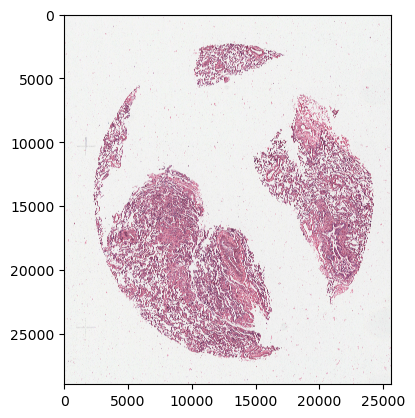

In [14]:
# view the wsi
from PIL import Image
from matplotlib import pyplot as plt
import random

plt.imshow(wsi.numpy())

In [48]:
def get_cell_ids_in_patch(sdata, patch_size=224, log_file=None):
    '''
    Input:
    sdata: spatialdata object
    patch_range: a tuple of (x_start, x_end, y_start, y_end)

    Output:
    patch_id_to_cell_id: a dict that maps each patch id (y_patch_idx, x_patch_idx) to a list of cell ids
    '''
    
    patch_id_to_cell_id = dict()
    # initialize a dict to hold cell ids by patch
    # {(y_patch_idx, x_patch_idx): [cell_ids]}
    for cid, point in sdata['locations']['geometry'].items():

        # get id and coord of cell
        x_center, y_center = point.x, point.y

        # find y, x index of the bucket this cell should be in
        y_patch_idx = y_center // patch_size
        x_patch_idx = x_center // patch_size

        # if the patch is not in the dict, create it
        patch_key = (y_patch_idx, x_patch_idx)
        if patch_key not in patch_id_to_cell_id:
            patch_id_to_cell_id[patch_key] = []

        # append the cell
        patch_id_to_cell_id[patch_key].append(cid)
    
    cell_counts = [len(cell_ids) for cell_ids in patch_id_to_cell_id.values()]

    # collect stats
    if log_file is not None:
        with open(log_file, 'a') as f:
            f.write(f"HE Nucleus Mask of dimension: {he_nuc_mask.shape}\n")
            f.write(f"Number of cells in this slide: {len(regions)}\n")
            f.write(f"Number of patches: {len(patch_id_to_cell_id)}\n")
            f.write(f"Patch size: {patch_size}\n")
            if cell_counts:
                f.write(f"Minimum number of cells in a patch: {min(cell_counts)}\n")
                f.write(f"Maximum number of cells in a patch: {max(cell_counts)}\n")
                f.write(f"Average number of cells in a patch: {np.mean(cell_counts):.3f}\n")
            else:
                f.write("No cells found in any patches.\n")

    return patch_id_to_cell_id

eventually get to the below

In [77]:
patch_id_to_cell_id

{(1.0, 39.0): [0],
 (1.0, 41.0): [1],
 (1.0, 43.0): [2],
 (1.0, 45.0): [3],
 (1.0, 47.0): [4],
 (1.0, 49.0): [5],
 (1.0, 51.0): [6],
 (1.0, 53.0): [7],
 (1.0, 55.0): [8],
 (1.0, 57.0): [9],
 (1.0, 60.0): [10],
 (1.0, 62.0): [11],
 (1.0, 64.0): [12],
 (1.0, 66.0): [13],
 (1.0, 68.0): [14],
 (1.0, 70.0): [15],
 (1.0, 72.0): [16],
 (1.0, 74.0): [17],
 (1.0, 76.0): [18],
 (3.0, 39.0): [19],
 (3.0, 41.0): [20],
 (3.0, 43.0): [21],
 (3.0, 45.0): [22],
 (3.0, 47.0): [23],
 (3.0, 49.0): [24],
 (3.0, 51.0): [25],
 (3.0, 53.0): [26],
 (3.0, 55.0): [27],
 (3.0, 57.0): [28],
 (3.0, 60.0): [29],
 (3.0, 62.0): [30],
 (3.0, 64.0): [31],
 (3.0, 66.0): [32],
 (3.0, 68.0): [33],
 (3.0, 70.0): [34],
 (3.0, 72.0): [35],
 (3.0, 74.0): [36],
 (3.0, 76.0): [37],
 (5.0, 39.0): [38],
 (5.0, 41.0): [39],
 (5.0, 43.0): [40],
 (5.0, 45.0): [41],
 (5.0, 47.0): [42],
 (5.0, 49.0): [43],
 (5.0, 51.0): [44],
 (5.0, 53.0): [45],
 (5.0, 55.0): [46],
 (5.0, 57.0): [47],
 (5.0, 60.0): [48],
 (5.0, 62.0): [49],
 (5.0, 64.

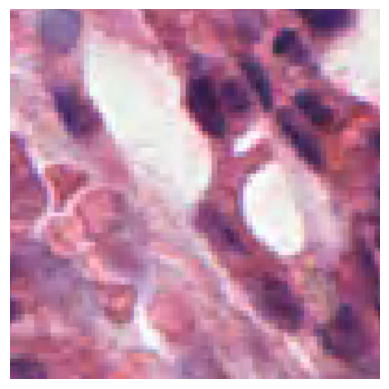

In [78]:
region = wsi.read_region(location=(11872, 22176), level=0, size=(200, 200))
img = region 
plt.imshow(img)
plt.axis('off')
plt.show()


In [49]:
patch_id_to_cell_id = get_cell_ids_in_patch(sdata, patch_size=224)

In [55]:
patch_id_to_cell_id

{(1.0, 39.0): [0],
 (1.0, 41.0): [1],
 (1.0, 43.0): [2],
 (1.0, 45.0): [3],
 (1.0, 47.0): [4],
 (1.0, 49.0): [5],
 (1.0, 51.0): [6],
 (1.0, 53.0): [7],
 (1.0, 55.0): [8],
 (1.0, 57.0): [9],
 (1.0, 60.0): [10],
 (1.0, 62.0): [11],
 (1.0, 64.0): [12],
 (1.0, 66.0): [13],
 (1.0, 68.0): [14],
 (1.0, 70.0): [15],
 (1.0, 72.0): [16],
 (1.0, 74.0): [17],
 (1.0, 76.0): [18],
 (3.0, 39.0): [19],
 (3.0, 41.0): [20],
 (3.0, 43.0): [21],
 (3.0, 45.0): [22],
 (3.0, 47.0): [23],
 (3.0, 49.0): [24],
 (3.0, 51.0): [25],
 (3.0, 53.0): [26],
 (3.0, 55.0): [27],
 (3.0, 57.0): [28],
 (3.0, 60.0): [29],
 (3.0, 62.0): [30],
 (3.0, 64.0): [31],
 (3.0, 66.0): [32],
 (3.0, 68.0): [33],
 (3.0, 70.0): [34],
 (3.0, 72.0): [35],
 (3.0, 74.0): [36],
 (3.0, 76.0): [37],
 (5.0, 39.0): [38],
 (5.0, 41.0): [39],
 (5.0, 43.0): [40],
 (5.0, 45.0): [41],
 (5.0, 47.0): [42],
 (5.0, 49.0): [43],
 (5.0, 51.0): [44],
 (5.0, 53.0): [45],
 (5.0, 55.0): [46],
 (5.0, 57.0): [47],
 (5.0, 60.0): [48],
 (5.0, 62.0): [49],
 (5.0, 64.

In [57]:
wsi

<width=25630, height=28964, backend=OpenSlideWSI>

In [56]:
# Get slide dimensions at level 0 (highest resolution)
width, height = wsi.dimensions

# Read a region at (x, y) with width w and height h from a specific level
region = wsi.read_region(location=(53, 108), level=0, size=(224, 224))

# region is a PIL.Image.Image
region.show()  # Or convert to NumPy array for processing

AttributeError: 'OpenSlideWSI' object has no attribute 'dimensions'

In [ ]:
he_image = np.transpose(sdata['HE_original'].to_numpy(), (1, 2, 0))
he_pil = Image.fromarray(he_image.astype(np.uint8))

In [8]:
patch_id_to_pil = match_patch_id_to_PIL(sdata, patch_id_to_cell_id, patch_size=224)

KeyError: "Could not find element with name 'HE_original'"

In [ ]:


patch_id_to_cell_id, patch_id_to_pil, patch_id_to_expr = match_patch_id_to_expr(sdata, patch_id_to_cell_id, patch_id_to_pil)